In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pickle_file = 'SVHN_digits_3_2_1_64x64x1_valid.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['valid_data']
    train_labels = save['valid_target']
    del save  # hint to help gc free up memory
    print('train set', train_dataset.shape, train_labels.shape)

train set (5518, 1, 64, 64) (5518, 6)


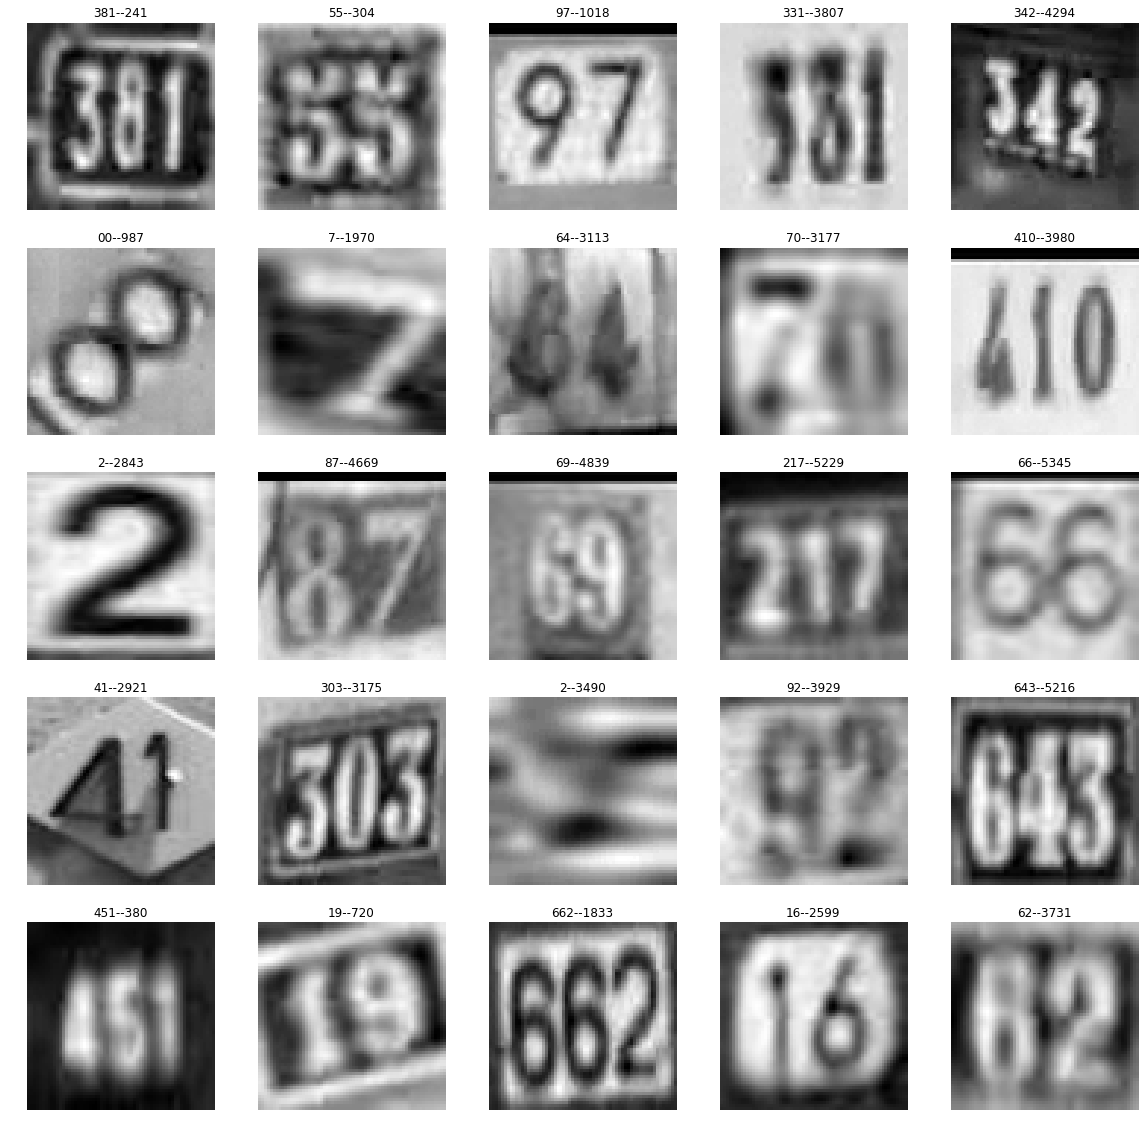

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=5, ncols=5)

im_samples = []

for row in range(5):
    for i, j in enumerate(np.sort(np.random.randint(0, train_labels.shape[0], size=5))):
        im = train_dataset[j].reshape((64, 64, 1))
        house_num = ''
        for k in np.arange(train_labels[j,0]):
            house_num += str(train_labels[j,k+1])
        house_num += "--" + str(j)
        im_samples.extend([j])
        ax[row, i].axis('off')
        ax[row, i].set_title(house_num, loc='center')
        ax[row, i].imshow(im[:,:,0], cmap='gray')

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 40, 3, padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 80, 3, padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(80)
        self.conv4 = nn.Conv2d(80, 120, 3, padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(120)
        self.conv5 = nn.Conv2d(120, 160, 3, padding=(1, 1))
        self.bn5 = nn.BatchNorm2d(160)
        self.conv6 = nn.Conv2d(160, 200, 3, padding=(1, 1))
        self.bn6 = nn.BatchNorm2d(200)
        self.conv7 = nn.Conv2d(200, 240, 3, padding=(1, 1))
        self.bn7 = nn.BatchNorm2d(240)
        self.pool = nn.MaxPool2d(2, 2)
        self.FC = nn.Linear(960, 1080)
        self.bn8 = nn.BatchNorm1d(1080)
        self.digitlength = nn.Linear(1080, 7)
        self.digit1 = nn.Linear(1080, 10)
        self.digit2 = nn.Linear(1080, 10)
        self.digit3 = nn.Linear(1080, 10)
        self.digit4 = nn.Linear(1080, 10)
        self.digit5 = nn.Linear(1080, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))
        x = self.pool(self.bn7(F.relu(self.conv7(x))))
        x = x.view(-1, 960)
        x = self.bn8(F.relu(self.FC(x)))
        yl = self.digitlength(x)
        y1 = self.digit1(x)
        y2 = self.digit2(x)
        y3 = self.digit3(x)
        y4 = self.digit4(x)
        y5 = self.digit5(x)
        return [yl, y1, y2, y3, y4, y5]

In [5]:
net = Net()
net.cuda()

Net (
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(80, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(120, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True)
  (conv6): Conv2d(160, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
  (conv7): Conv2d(200, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn7): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True)
  (p

In [6]:
for param in net.parameters():
    if(param.grad is not None):
        print(param)

In [4]:
c3_ = []
c2_ = []
c1_ = []
for i in range(500, 3500):
    d = train_labels[i, 0]
    if (d == 1):
        c1_.append(i)
    elif (d == 2):
        c2_.append(i)
    elif (d == 3):
        c3_.append(i)

In [5]:
print(len(c3_), len(c2_), len(c1_))

867 1595 538


In [7]:
c = c3_[:500] + c2_[:500] + c1_[:500]
print(len(c))

1500


In [9]:
small_data = train_dataset[c]
small_target = train_labels[c]

In [10]:
rng_state = np.random.get_state()
X = np.random.permutation(small_data)

In [11]:
np.random.set_state(rng_state)
Y = np.random.permutation(small_target)

In [12]:
import os

In [13]:
pickle_file = 'small_321_valid.pickle'
try:
    f = open(pickle_file, 'wb')
    save = {
        'small_data': X,
        'small_target': Y
            }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 24612270


In [7]:
data_tensor = torch.from_numpy(train_dataset)
target_tensor = torch.from_numpy(train_labels).type(torch.LongTensor)
print(data_tensor.type(), data_tensor.size())
print(target_tensor.type(), target_tensor.size())

torch.FloatTensor torch.Size([91443, 1, 64, 64])
torch.LongTensor torch.Size([91443, 6])


In [8]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [12]:
num_epochs = 20
batch_size = 64
num_train = 500 #data_tensor.size()[0]
iter_per_epoch = num_train // batch_size
print_every = 3
print(iter_per_epoch)

7


In [13]:
epoch_losses = {i:[] for i in range(num_epochs)}
loss_history = []

In [18]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 110)

    i = 0
    rng_state = torch.get_rng_state()
    new_idxs = torch.randperm(num_train)
    
    t1 = time.time()
    for t in range(iter_per_epoch):
        batch_idxs = new_idxs[i: i+batch_size]
        i += batch_size
        X_batch = data_tensor[batch_idxs]
        Y_batch = target_tensor[batch_idxs][:,0:4]
        lenths = Y_batch[:, 0]
        bin3 = []
        bin2 = []
        bin1 = []
        for idx, lenth in enumerate(lenths):
            if (lenth == 1):
                bin1.append(idx)
            elif (lenth == 2):
                bin2.append(idx)
            elif (lenth == 3):
                bin3.append(idx)
        

        X_batch = Variable(X_batch).cuda()
        optimizer.zero_grad()
        outputs = net(X_batch)
        
        if bin3:
            idxs = torch.LongTensor(bin3).cuda()
            lossl = objective(outputs[0][idxs], Y_batch[idxs, 0])
            loss1 = objective(outputs[1][idxs], Y_batch[idxs, 1])
            loss2 = objective(outputs[2][idxs], Y_batch[idxs, 2])
            loss3 = objective(outputs[3][idxs], Y_batch[idxs, 3])
            lossd3 = lossl + loss1 + loss2 + loss3
            lossd3.backward(retain_variables=True)
        
        if bin2:
            idxs = torch.LongTensor(bin2).cuda()
            lossl = objective(outputs[0][idxs], Y_batch[idxs, 0])
            loss1 = objective(outputs[1][idxs], Y_batch[idxs, 1])
            loss2 = objective(outputs[2][idxs], Y_batch[idxs, 2])
            lossd2 = lossl + loss1 + loss2
            lossd2.backward(retain_variables=True)
        
        if bin1:
            idxs = torch.LongTensor(bin1).cuda()
            lossl = objective(outputs[0][idxs], Y_batch[idxs, 0])
            loss1 = objective(outputs[1][idxs], Y_batch[idxs, 1])
            lossd1 = lossl + loss1
            lossd1.backward()
        
        optimizer.step()
        final_loss = loss3d + loss2d + loss1d
        
        loss_history.append(final_loss.data[0])
        epoch_losses[epoch].append(final_loss.data[0])
        
        if (t % print_every == 0):
            print('Iteration : ', t+1, ' / ', iter_per_epoch)
            print('loss : ', final_loss.data[0])
            print('loss3d : ', loss3d.data[0], 'loss2d : ', loss2d.data[0], 'loss1d : ', loss1d.data[0])
        
    t2 = time.time()
    print("time taken : ", t2-t1)
    print('-' * 110)
        

Epoch 0/19
--------------------------------------------------------------------------------------------------------------


TypeError: indexing a tensor with an object of type LongTensor. The only supported types are integers, slices, numpy scalars and torch.cuda.LongTensor or torch.cuda.ByteTensor as the only argument.

In [ ]:
arrayidx = torch.randperm(5)
print(arrayidx)

In [ ]:
print(a[arrayidx])

In [ ]:
f = open("c3_leg_ep_20.pkl", "bw")
torch.save(net.state_dict(), f)
f.close()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.figure()
plt.plot(loss_history)